# Modeling similarity judgments with word embeddings

Previous work has illustrated that similarity judgments between words can be estimated using distributional models of word meaning. But are there certain kinds of words for which distributioanl information is more or less useful?

There are theoretical reasons to think that distributional information is more helpful for learning abstract concepts/words (Lupyan & Winter, 2018), and some empirical evidence as well (Kiros et al, 2018). But so far, others have not asked whether distributional information better predicts similarity judgments as a function of the *level of abstractness* of a word, or other kinds of semantic features. 

We use the Brysbaert norms as an estimate of concreteness, and ELMo as a model for word embeddings.

For the pairwise similarity judgments, we will consider several different datasets in turn.

For a given dataset, we classify each wordpair into one of three bins: `Abstract`, `Concrete`, and `Mixed`. `Abstract` corresponds to a wordpair in which both words fall below the median concreteness, `Concrete` corresponds to a wordpair in which both words fall above, and `Mixed` means that one falls below and one falls above.

We then regress `similarity ~ cosine_distance` for Abstract wordpairs only, and Concrete wordpairs only, and compare the resulting `R^2` values.

### Median split 

Because each dataset isn't balanced in terms of its concreteness, we can't necessarily use the median split from the Brysbaert norms. Thus, we run and report two approaches to splitting the data:

1) Using the median concreteness from a given dataset.  
2) Using the median concreteness from the four datasets we consider.

(1) will ensure that a given dataset is balanced, but might result in the same words being considered `Abstract` or `Concrete` in different datasets.

(2) will result in less balanced datasets, but still more balanced than using the single Brysbaert norm, and will ensure consistency in which words are categorized as `Abstract` or `Concrete` across datasets.


In [1]:
import pandas as pd
from tqdm import tqdm
import itertools
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import statsmodels.formula.api as sm
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

# Helper functions

In [3]:
def get_comparison_type(row):
    if row['w1_is_abstract'] and row['w2_is_abstract']:
        return "Abstract"
    elif not row['w1_is_abstract'] and not row['w2_is_abstract']:
        return "Concrete"
    return "Mixed"

In [4]:
def tag_as_abstract(df, median_concreteness_amount):
    """Tag each word in a word pair as whether it is concrete, according to the median concreteness."""
    df['w1_is_abstract'] = df['w1_conc'].apply(lambda x: x < median_concreteness_amount)
    df['w2_is_abstract'] = df['w2_conc'].apply(lambda x: x < median_concreteness_amount)
    df['same'] = df['w1_is_abstract'] == df['w2_is_abstract']
    return df

In [5]:
def print_distribution(df):
    """Print out dataset distribution in terms of comparisons."""
    print("#Abstract: {n}".format(n=len(df[df['Comparison Type']=='Abstract'])))
    print("#Concrete: {n}".format(n=len(df[df['Comparison Type']=='Concrete'])))
    print("#Mixed: {n}".format(n=len(df[df['Comparison Type']=='Mixed'])))

In [6]:
def get_stats_for_dataset(df, formula, dataset):
    """Get R2 and coefficients for different subsets of dataset."""
    results = []
    result = sm.ols(formula=FORMULA, 
                data=df).fit()
    results.append({
        'comparison': 'overall',
        'r2': round(result.rsquared, 3),
        'coef': round(result.params['decontextualized_elmo_similarity'], 3),
        'se': round(result.bse['decontextualized_elmo_similarity'], 3),
        'dataset': dataset,
        'n': len(df)
    })
    for i in ['Abstract', 'Concrete', 'Mixed']:
        df_reduced = df[df['Comparison Type']==i]
        result = sm.ols(formula=FORMULA, 
                    data=df_reduced).fit()
        results.append({
            'comparison': i,
            'r2': round(result.rsquared, 3),
            'coef': round(result.params['decontextualized_elmo_similarity'], 3),
            'se': round(result.bse['decontextualized_elmo_similarity'], 3),
            'dataset': dataset,
            'n': len(df_reduced)
        })
    
    return pd.DataFrame(results)

In [7]:
FORMULA = 'similarity ~ decontextualized_elmo_similarity'

In [8]:
def leave_one_pair_out(df, formula):
    
    result = sm.ols(formula=formula, 
                data=df).fit()
    original_coef = result.params['decontextualized_elmo_similarity']
    
    differences = []
    for pair_index in tqdm(range(len(df))):
        df_copy = df.copy()
        df_copy = df_copy.drop(pair_index)
        
        result = sm.ols(formula=formula, 
            data=df_copy).fit()
        new_coef = result.params['decontextualized_elmo_similarity']
        differences.append(original_coef - new_coef)
    return differences

# Load datasets

Load each processed dataset and print out descriptive statistics for it.

In [9]:
df_sim = pd.read_csv("data/processed/sim3500_with_cosine_distance_5b.csv")
combined_sim = list(df_sim['w1']) + list(df_sim['w2'])
print(len(df_sim))
print(len(set(combined_sim)))

3487
824


In [10]:
df_wordsim = pd.read_csv("data/processed/wordsim_with_cosine_distance_5b.csv")
combined_wordsim = list(df_wordsim['Word 1']) + list(df_wordsim['Word 2'])
print(len(df_wordsim))
print(len(set(combined_wordsim)))

353
437


In [11]:
df_simlex = pd.read_csv("data/processed/simlex_with_cosine_distance_5b.csv")
combined_simlex = list(df_simlex['word1']) + list(df_simlex['word2'])
print(len(df_simlex))
print(len(set(combined_simlex)))

999
1028


In [12]:
df_mturk = pd.read_csv("data/processed/mturk771_with_cosine_distance_5b.csv")
combined_mturk = list(df_mturk['w1']) + list(df_mturk['w2'])
print(len(df_mturk))
print(len(set(combined_mturk)))

754
1094


## Descriptive statistics about concreteness

In [13]:
combined = list(df_sim['w1_conc']) +  list(df_sim['w2_conc'])
simverb_conc = statistics.median(combined)
simverb_conc

3.03

In [14]:
combined = list(df_wordsim['w1_conc']) +  list(df_wordsim['w2_conc'])
wordsim_conc = statistics.median(combined)
wordsim_conc

3.94

In [15]:
combined = list(df_simlex['w1_conc']) +  list(df_simlex['w2_conc'])
simlex_conc = statistics.median(combined)
simlex_conc

3.73

In [16]:
combined = list(df_mturk['w1_conc']) +  list(df_mturk['w2_conc'])
mturk_conc = statistics.median(combined)
mturk_conc

4.1

In [17]:
median_conc = statistics.median([simverb_conc, wordsim_conc, simlex_conc, mturk_conc])
median_conc

3.835

# Analysis

## SimVerb

### Approach 1: Using median concreteness for dataset

In [18]:
df_sim = tag_as_abstract(df_sim, simverb_conc)
df_sim['Comparison Type'] = df_sim.apply(lambda row: get_comparison_type(row), axis=1)
print_distribution(df_sim)

#Abstract: 1164
#Concrete: 1179
#Mixed: 1144


In [19]:
simverb1 = get_stats_for_dataset(df_sim, FORMULA, "SimVerb")
simverb1

,coef,comparison,dataset,n,r2,se
0,-10.740,overall,SimVerb,3487,0.207,0.356
1,-10.068,Abstract,SimVerb,1164,0.213,0.567
2,-9.074,Concrete,SimVerb,1179,0.129,0.686
3,-13.005,Mixed,SimVerb,1144,0.263,0.644


### Approach 2: Using median concreteness across all four datasets

In [20]:
df_sim = tag_as_abstract(df_sim, median_conc)
df_sim['Comparison Type'] = df_sim.apply(lambda row: get_comparison_type(row), axis=1)
print_distribution(df_sim)

#Abstract: 2223
#Concrete: 399
#Mixed: 865


In [21]:
simverb2 = get_stats_for_dataset(df_sim, FORMULA, "SimVerb")
simverb2

,coef,comparison,dataset,n,r2,se
0,-10.740,overall,SimVerb,3487,0.207,0.356
1,-10.810,Abstract,SimVerb,2223,0.224,0.428
2,-4.305,Concrete,SimVerb,399,0.027,1.299
3,-13.153,Mixed,SimVerb,865,0.260,0.756


## Wordsim

### Approach 1: Using median concreteness for dataset

In [22]:
df_wordsim = tag_as_abstract(df_wordsim, wordsim_conc)
df_wordsim['Comparison Type'] = df_wordsim.apply(lambda row: get_comparison_type(row), axis=1)
print_distribution(df_wordsim)

#Abstract: 101
#Concrete: 138
#Mixed: 114


In [23]:
wordsim1 = get_stats_for_dataset(df_wordsim, FORMULA, "WordSim")
wordsim1

,coef,comparison,dataset,n,r2,se
0,-7.984,overall,WordSim,353,0.319,0.622
1,-8.351,Abstract,WordSim,101,0.405,1.018
2,-7.196,Concrete,WordSim,138,0.267,1.023
3,-10.189,Mixed,WordSim,114,0.268,1.592


### Approach 2: Using median concreteness across all four datasets

In [24]:
df_wordsim = tag_as_abstract(df_wordsim, median_conc)
df_wordsim['Comparison Type'] = df_wordsim.apply(lambda row: get_comparison_type(row), axis=1)
print_distribution(df_wordsim)

#Abstract: 95
#Concrete: 150
#Mixed: 108


In [25]:
wordsim2 = get_stats_for_dataset(df_wordsim, FORMULA, "WordSim")
wordsim2

,coef,comparison,dataset,n,r2,se
0,-7.984,overall,WordSim,353,0.319,0.622
1,-8.706,Abstract,WordSim,95,0.448,1.003
2,-7.001,Concrete,WordSim,150,0.254,0.986
3,-9.991,Mixed,WordSim,108,0.265,1.618


## SimLex

### Approach 1: Using median concreteness for dataset

In [26]:
df_simlex = tag_as_abstract(df_simlex, simlex_conc)
df_simlex['Comparison Type'] = df_simlex.apply(lambda row: get_comparison_type(row), axis=1)
print_distribution(df_simlex)

#Abstract: 433
#Concrete: 434
#Mixed: 132


In [27]:
simlex1 = get_stats_for_dataset(df_simlex, FORMULA, "SimLex")
simlex1

,coef,comparison,dataset,n,r2,se
0,-7.915,overall,SimLex,999,0.200,0.502
1,-9.759,Abstract,SimLex,433,0.215,0.899
2,-6.714,Concrete,SimLex,434,0.191,0.664
3,-8.911,Mixed,SimLex,132,0.276,1.265


### Approach 2: Using median concreteness across all four datasets

In [28]:
df_simlex = tag_as_abstract(df_simlex, median_conc)
df_simlex['Comparison Type'] = df_simlex.apply(lambda row: get_comparison_type(row), axis=1)
print_distribution(df_simlex)

#Abstract: 451
#Concrete: 427
#Mixed: 121


In [29]:
simlex2 = get_stats_for_dataset(df_simlex, FORMULA, "SimLex")
simlex2

,coef,comparison,dataset,n,r2,se
0,-7.915,overall,SimLex,999,0.200,0.502
1,-9.495,Abstract,SimLex,451,0.208,0.875
2,-6.692,Concrete,SimLex,427,0.188,0.676
3,-9.133,Mixed,SimLex,121,0.291,1.306


## MTurk

### Approach 1: Using median concreteness for dataset

In [30]:
df_mturk = tag_as_abstract(df_mturk, mturk_conc)
df_mturk['Comparison Type'] = df_mturk.apply(lambda row: get_comparison_type(row), axis=1)
print_distribution(df_mturk)

#Abstract: 244
#Concrete: 246
#Mixed: 264


In [31]:
mturk1 = get_stats_for_dataset(df_mturk, FORMULA, "MTurk")
mturk1

,coef,comparison,dataset,n,r2,se
0,-4.582,overall,MTurk,754,0.375,0.216
1,-4.861,Abstract,MTurk,244,0.424,0.364
2,-4.487,Concrete,MTurk,246,0.344,0.396
3,-4.789,Mixed,MTurk,264,0.361,0.394


### Approach 2: Using median concreteness across all four datasets

In [32]:
df_mturk = tag_as_abstract(df_mturk, median_conc)
df_mturk['Comparison Type'] = df_mturk.apply(lambda row: get_comparison_type(row), axis=1)
print_distribution(df_mturk)

#Abstract: 195
#Concrete: 322
#Mixed: 237


In [33]:
mturk2 = get_stats_for_dataset(df_mturk, FORMULA, "MTurk")
mturk2

,coef,comparison,dataset,n,r2,se
0,-4.582,overall,MTurk,754,0.375,0.216
1,-4.588,Abstract,MTurk,195,0.413,0.394
2,-4.340,Concrete,MTurk,322,0.337,0.340
3,-5.224,Mixed,MTurk,237,0.364,0.451


## Visualizations

In [34]:
def grouped_barplot(df, cat, subcat, val, err, x_label, y_label, title, fig_path):
    """Just for making barplots with error bars."""
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{}".format(gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.savefig(fig_path, dpi=300)
    plt.show()
    

### Approach 1

In [35]:
df_approach1 = pd.concat([simverb1, wordsim1, simlex1, mturk1])
df_just_abs_conc = df_approach1[df_approach1['comparison'].isin(['Abstract', 'Concrete'])]

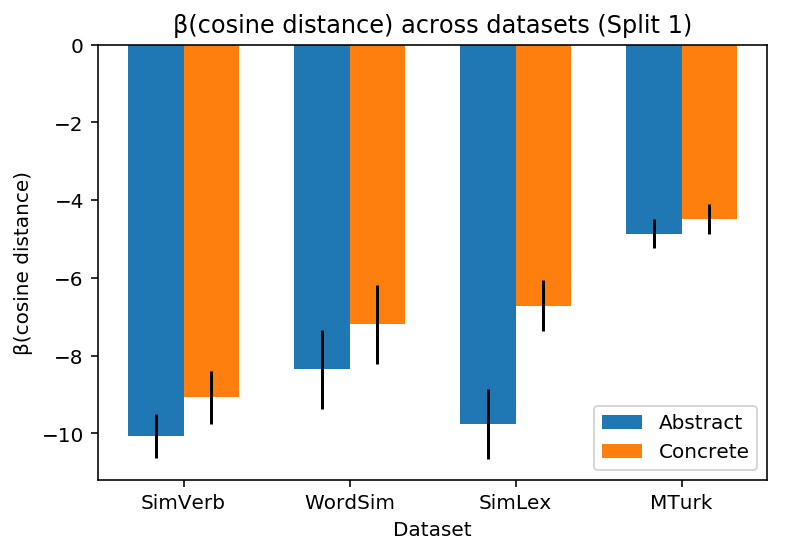

In [36]:
grouped_barplot(df_just_abs_conc, 'dataset', 'comparison', 'coef', 'se',
               x_label = 'Dataset',
               y_label = "\u03B2(cosine distance)",
               title = "\u03B2(cosine distance) across datasets (Split 1)",
               fig_path = "Figures/overall_fits/all_models_approach1_5b.png")

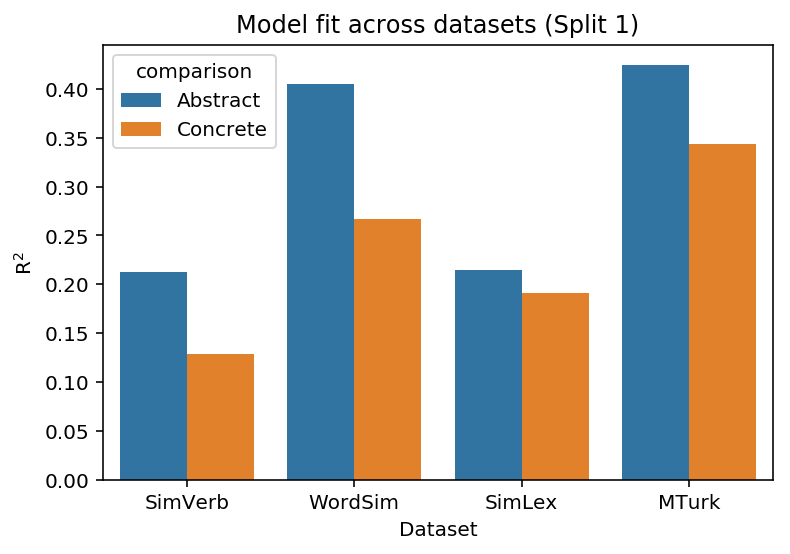

In [37]:
sns.barplot(data = df_just_abs_conc,
             x = "dataset",
             y = "r2",
             hue = "comparison")
plt.xlabel("Dataset")
plt.ylabel("R$^2$")
plt.title("Model fit across datasets (Split 1)")
plt.savefig("Figures/overall_fits/r2_approach1_5b.png", dpi=300)

### Approach 2

In [38]:
df_approach2 = pd.concat([simverb2, wordsim2, simlex2, mturk2])
df_just_abs_conc = df_approach2[df_approach2['comparison'].isin(['Abstract', 'Concrete'])]

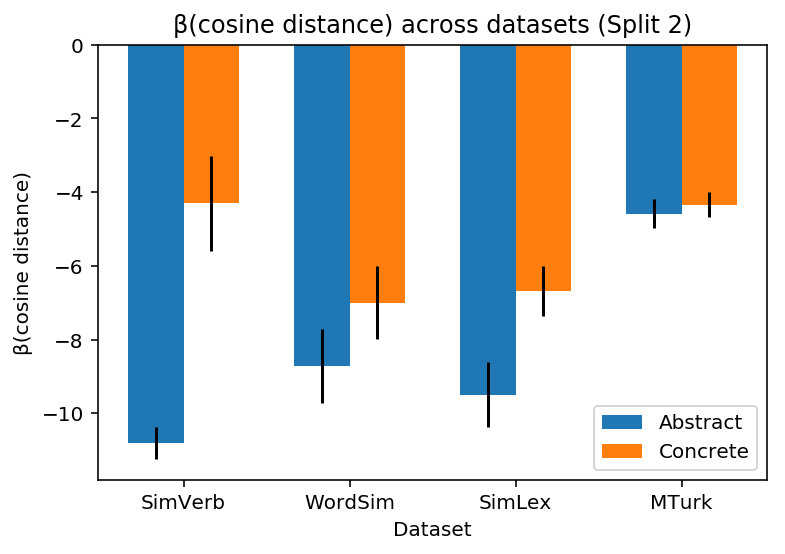

In [39]:
grouped_barplot(df_just_abs_conc, 'dataset', 'comparison', 'coef', 'se',
               x_label = 'Dataset',
               y_label = "\u03B2(cosine distance)",
               title = "\u03B2(cosine distance) across datasets (Split 2)",
               fig_path = "Figures/overall_fits/all_models_approach2_5b.png")

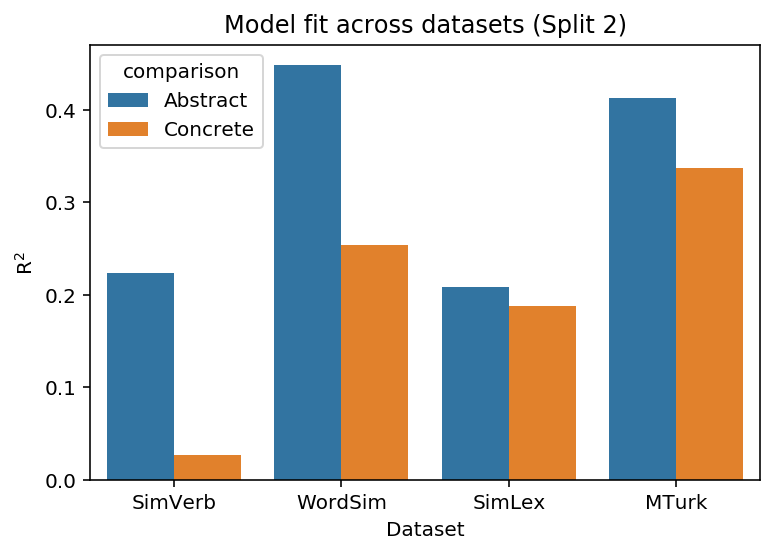

In [40]:
sns.barplot(data = df_just_abs_conc,
             x = "dataset",
             y = "r2",
             hue = "comparison")
plt.xlabel("Dataset")
plt.ylabel("R$^2$")
plt.title("Model fit across datasets (Split 2)")
plt.savefig("Figures/overall_fits/r2_approach2_5b.png", dpi=300)

### Measures of effect size

We can also quantify the average effect size as the **difference** in a given test statistic across Abstract and Concrete subsets.

In [61]:
abstract_approach1 = df_approach1[df_approach1['comparison']=="Abstract"]
concrete_approach1 = df_approach1[df_approach1['comparison']=="Concrete"]
coef_diff_approach1 = abstract_approach1['coef'].values - concrete_approach1['coef'].values
r2_diff_approach1 = abstract_approach1['r2'].values - concrete_approach1['r2'].values

In [64]:
abstract_approach2 = df_approach2[df_approach2['comparison']=="Abstract"]
concrete_approach2 = df_approach2[df_approach2['comparison']=="Concrete"]
coef_diff_approach2 = abstract_approach2['coef'].values - concrete_approach2['coef'].values
r2_diff_approach2 = abstract_approach2['r2'].values - concrete_approach2['r2'].values

### Average difference for a given dataset across splits

In [72]:
(coef_diff_approach1 + coef_diff_approach2) / 2

array([-3.7495, -1.43  , -2.924 , -0.311 ])

In [76]:
(r2_diff_approach1 + r2_diff_approach2) / 2

array([0.1405, 0.166 , 0.022 , 0.078 ])

### Average effect size across datasets for a given split

In [92]:
print(round(coef_diff_approach1.mean(), 2))
print("SE: {x}".format(x=round(coef_diff_approach1.std()/2, 2)))

-1.39
SE: 0.5


In [93]:
print(round(coef_diff_approach2.mean(), 2))
print("SE: {x}".format(x=round(coef_diff_approach2.std()/2, 2)))

-2.82
SE: 1.16


In [94]:
print(round(r2_diff_approach1.mean(), 2))
print("SE: {x}".format(x=round(r2_diff_approach1.std()/2, 2)))

0.08
SE: 0.02


In [95]:
print(round(r2_diff_approach2.mean(), 2))
print("SE: {x}".format(x=round(r2_diff_approach2.std()/2, 2)))

0.12
SE: 0.04


## Supplementary materials

### Overall results

In [68]:
df_approach1[df_approach1['comparison'].isin(['Abstract', 'Concrete'])]

,coef,comparison,dataset,n,r2,se
1,-10.068,Abstract,SimVerb,1164,0.213,0.567
2,-9.074,Concrete,SimVerb,1179,0.129,0.686
1,-8.351,Abstract,WordSim,101,0.405,1.018
2,-7.196,Concrete,WordSim,138,0.267,1.023
1,-9.759,Abstract,SimLex,433,0.215,0.899
2,-6.714,Concrete,SimLex,434,0.191,0.664
1,-4.861,Abstract,MTurk,244,0.424,0.364
2,-4.487,Concrete,MTurk,246,0.344,0.396


In [72]:
df_approach2[df_approach2['comparison'].isin(['Abstract', 'Concrete'])]

,coef,comparison,dataset,n,r2,se
1,-10.810,Abstract,SimVerb,2223,0.224,0.428
2,-4.305,Concrete,SimVerb,399,0.027,1.299
1,-8.706,Abstract,WordSim,95,0.448,1.003
2,-7.001,Concrete,WordSim,150,0.254,0.986
1,-9.495,Abstract,SimLex,451,0.208,0.875
2,-6.692,Concrete,SimLex,427,0.188,0.676
1,-4.588,Abstract,MTurk,195,0.413,0.394
2,-4.340,Concrete,MTurk,322,0.337,0.340


### Results for Mixed and overall pairs

In [76]:
df_approach1[df_approach1['comparison'].isin(['Mixed', 'overall'])]

,coef,comparison,dataset,n,r2,se
0,-10.740,overall,SimVerb,3487,0.207,0.356
3,-13.005,Mixed,SimVerb,1144,0.263,0.644
0,-7.984,overall,WordSim,353,0.319,0.622
3,-10.189,Mixed,WordSim,114,0.268,1.592
0,-7.915,overall,SimLex,999,0.200,0.502
3,-8.911,Mixed,SimLex,132,0.276,1.265
0,-4.582,overall,MTurk,754,0.375,0.216
3,-4.789,Mixed,MTurk,264,0.361,0.394


In [77]:
df_approach2[df_approach2['comparison'].isin(['Mixed'])]

,coef,comparison,dataset,n,r2,se
3,-13.153,Mixed,SimVerb,865,0.260,0.756
3,-9.991,Mixed,WordSim,108,0.265,1.618
3,-9.133,Mixed,SimLex,121,0.291,1.306
3,-5.224,Mixed,MTurk,237,0.364,0.451


# Supplementary analysis

To ensure that the results of the primary analysis (see above) are not due to differences in the quality of the embeddings for concrete vs. abstract words, we conducted a supplementary analysis, correlating `frequency` (in the CELEX database) with `concreteness`.

If concrete words are either equally frequent, or more frequent, than abstract words, then it is unlikely our result simply reflects a decrease in the quality of the embeddings for concrete words. Indeed, we find that concreteness correlates positively with frequency.

## Analysis 1: All Brysbaert words

In [43]:
import pandas as pd
import math

In [44]:
df_freq = pd.read_csv("data/freq.csv", delim_whitespace=True)
df_brysbaert = pd.read_csv("data/brysbaert_norms.csv")

In [45]:
df_freq['log_freq'] = df_freq['Frequency'].apply(lambda x: math.log10(x))

In [46]:
df_merged = pd.merge(df_freq, df_brysbaert, on="Word")
df_merged['Concreteness'] = df_merged['Conc.M']
len(df_merged)

35207

In [49]:
model = sm.ols(data = df_merged,
       formula = "Concreteness ~ log_freq"
      ).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Concreteness   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1315.
Date:                Thu, 19 Dec 2019   Prob (F-statistic):          1.19e-282
Time:                        12:53:13   Log-Likelihood:                -49819.
No. Observations:               35207   AIC:                         9.964e+04
Df Residuals:                   35205   BIC:                         9.966e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4965      0.015    168.423      0.000       2.467       2.526
log_freq       0.1657      0.005     36.258      0.000       0.157       0.175
==============================================================================
Omnibus:                     8730.417   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2156.301
Skew:                           0.343   Prob(JB):                         0.00
Kurtosis:                       2.000   Cond. No.                         9.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analysis 2: Each similarity dataset

Now, we ask whether for the **specific words** we analyzed, there is a positive, negative, or null relationship between `Concreteness` and `Frequency`.

In [50]:
sim_words = pd.DataFrame.from_dict({'Word': combined_sim})
wordsim_words = pd.DataFrame.from_dict({'Word': combined_wordsim})
simlex_words = pd.DataFrame.from_dict({'Word': combined_simlex})
mturk_words = pd.DataFrame.from_dict({'Word': combined_mturk})

In [51]:
all_words_list = combined_sim + combined_wordsim + combined_simlex + combined_mturk
all_words_list = list(set(all_words_list))
all_words = pd.DataFrame.from_dict({'Word': all_words_list})

In [52]:
new = []
for df in [sim_words, wordsim_words, simlex_words, mturk_words, all_words]:
    new_df = pd.merge(df, df_merged, on="Word")
    new.append(new_df)
sim_words, wordsim_words, simlex_words, mturk_words, all_words = new

In [53]:
len(all_words)

2601

In [54]:
model = sm.ols(data = all_words,
       formula = "Concreteness ~ log_freq"
      ).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Concreteness   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.053
Date:                Thu, 19 Dec 2019   Prob (F-statistic):             0.0807
Time:                        12:53:19   Log-Likelihood:                -3728.1
No. Observations:                2601   AIC:                             7460.
Df Residuals:                    2599   BIC:                             7472.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3553      0.121     27.770      0.000       3.118       3.592
log_freq       0.0462      0.026      1.747      0.081      -0.006       0.098
==============================================================================
Omnibus:                     1579.555   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.661
Skew:                          -0.258   Prob(JB):                     1.18e-38
Kurtosis:                       1.840   Cond. No.                         29.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""